## Producing Portfolios
In order to produce a portfolio that matches the preferences of the user, it is necessary to create a metric that weighs risk from different aspects of the Defi Coins

The procedure to formulate this measure is as follows.

**Initial requirements:** Historial price data from each asset is needed to calculate the mean returns and price covariance between assets. In addition to that data, a real number in the range [0, 1] exists for each coin that represents the risk inherent in the security of the protocol and the public sentiment toward the coin

A typical covariance matrix is made from the price data of the coins. That matrix, by definition, is a symmetric matrix with the rows and columns representing the different coins. Each value in the matrix is the covariance between two coins. The variance between a coin and itself is 1.

In [623]:
## import modules

import typing as typ
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import logging

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.cla import CLA
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting


## typing
Preferences = typ.Dict
## example prefs
ex_pref = {
    'risk_appetite': 'low',
    'term': 'long',
    'capital': 100,
    'sens': []
}

## price data
full_data = pd.read_csv("/home/gloria/projects/cibr-qcri/defi-robo-advisor/services/portfolio/test_data.csv", index_col="day")
new_data = pd.read_csv('new_data.txt', index_col="day")
## clean df
index_len = len(full_data.index)
new_index = np.arange(0, index_len, 1)
full_data.index = new_index
full_data = pd.concat([full_data, new_data], axis=1)
full_data.index.rename('Day', inplace=True)


# how many days to train
tr_days = 100
price_data = full_data.iloc[10:tr_days]


## sector information
sect_map = {
    'dai': 'lending',
    'uniswap': 'POW',
    'frax': 'deriv',
    'aave': 'POW',
    'chainlink': 'deriv',
    'maker': 'deriv'
}


## all the classes needed to create, monitor, and update a portfolio
        
class CoinAnalyzer:
    
    def __init__(self):
        pass

    ## get correlation between coins
    def correlation(coins: pd.DataFrame, verbose=False) -> np.ndarray:
        return coins.iloc[1:].corr()

    def mean(self, price: pd.DataFrame):
        return expected_returns.mean_historical_return(price, compounding=True)


    def plot_matrix(self, matrix, title):
        plt.matshow(matrix)

        plt.xticks(range(price_data.iloc[1:].select_dtypes(['number']).shape[1]), price_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
        plt.yticks(range(price_data.iloc[1:].select_dtypes(['number']).shape[1]), price_data.select_dtypes(['number']).columns, fontsize=14)
        cb = plt.colorbar()
        plt.clim(0, 3)
        cb.ax.tick_params(labelsize=14)

        plt.title(title)

        plt.show

    ## plot correlations of coins
    def corr_plot(self, df):
        mat = df.iloc[1:].corr()

        self.plot_matrix(mat)


    def cov_matrix(self, price: pd.DataFrame, prefs: Preferences, exp: bool):
        ## make df of price data
        ## put preferences into data, use security risks, prefs, etc
        if exp:
            r = risk_models.exp_cov(price, span=90, frequency=365)
        else:
            r = risk_models.risk_matrix(price, method='ledoit_wolf')
        num_coins = len(r.columns)
        
        ## generate alt risk matrix, uses prefs and security
        ## each coin should have a risk score from prefs 
        prefs_risk = np.zeros((num_coins, num_coins))

        np.fill_diagonal(prefs_risk, np.sqrt([1.9, 1.2, 1.3, 1.5, 1.7, 1.1, 1.2, 1.3]))
        prefs_risk = pd.DataFrame(prefs_risk, columns=r.columns)

        # print(prefs_risk)
        # print(prefs_risk.T.to_numpy())
        
        comprehensive_risk = (prefs_risk @ r) @ prefs_risk.T

        # print(comprehensive_risk)

        return comprehensive_risk
        


class CoinHandler:

    def __init__(self, n):
        self.coins = []
        self.corrs = np.zeros(n)

    ## get n coins from database
    def get_coins(self):
        ## initialize coins from database
        pass

    ## if daily change is more than 5%
    def check_change(self):
        ## get last two rows of df, use them to calc pct change
        ## if true, call Portfolio.rebalance
        pass


ALL_PORTFOLIOS = {}

class Portfolio:

    def __init__(self, user_id: str, name: str, prefs: Preferences):
        self.user = user_id
        self.name = name
        self.prefs = prefs
        self.created = datetime.date.today()
        self.last_rebal = self.created
        self.assets = {}
        self.cap = self.prefs['capital']
        self.ca = CoinAnalyzer()

        if self.user in ALL_PORTFOLIOS:
            ALL_PORTFOLIOS[self.user].append(self)
        else:
            ALL_PORTFOLIOS[self.user] = [self]

        self.create_portfolio()

    def __str__(self) -> str:
        return f'User {self.user} has this portfolio with {self.assets}'

    def update_prefs(self, new_prefs: Preferences):
        self.prefs.update(new_prefs)
        logging.debug('prefs updated')
        self.create_portfolio()


    ## function that plots effiecient frontier and randomly generated portfolios
    def plot_random_portfolios(self, e: EfficientFrontier):
        fig, ax = plt.subplots()
        ef_max_sharpe = copy.deepcopy(e)
        my_range = np.linspace(0.0, 1.5, 50)
        plotting.plot_efficient_frontier(e, ax=ax, show_assets=False, ef_param_range=my_range)

        # Find the tangency portfolio
        ef_max_sharpe.max_sharpe()
        ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(verbose=True)
        print(ef_max_sharpe.weights)
        ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

        # Generate random portfolios
        n_samples = 10000
        w = np.random.dirichlet(np.ones(e.n_assets), n_samples)
        rets = w.dot(e.expected_returns)
        stds = np.sqrt(np.diag(w @ e.cov_matrix @ w.T))
        sharpes = rets / stds
        ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

        # Output
        ax.set_title("Efficient Frontier with random portfolios")
        ax.legend()
        plt.tight_layout()
        plt.show()


    ## new portfolio. maybe consider sector constraints
    def create_portfolio(self, prices=price_data):
        mu = self.ca.mean(prices)
        S = self.ca.cov_matrix(prices, self.prefs, True)

        # self.ca.corr_plot(price_data)

        ef = EfficientFrontier(mu, S, solver='ECOS')

        sect_prefs = {}
        for sect in self.prefs['sens']:
            if sect == 'halal':
                sect_prefs['lending'] = 0
            elif sect == 'eco':
                sect_prefs['POW'] = 0

        ef.add_sector_constraints(sect_map, {}, sect_prefs)
        # self.plot_random_portfolios(copy.deepcopy(ef))

        if self.prefs['risk_appetite'] == 'low':
            ef.min_volatility()
            if ef.portfolio_performance()[0] < -0.05:
                # print("neg returns")
                ef = EfficientFrontier(mu, S)
                ef.add_sector_constraints(sect_map, {}, sect_prefs)
                try:
                    ef.efficient_risk(.1)
                except:
                    try:
                        ef = EfficientFrontier(mu, S)
                        ef.add_sector_constraints(sect_map, {}, sect_prefs)
                        ef.efficient_risk(.175)
                    except:
                        ef = EfficientFrontier(mu, S)
                        ef.add_sector_constraints(sect_map, {}, sect_prefs)
                        ef.efficient_risk(.25)
        elif self.prefs['risk_appetite'] == 'mid':
            try:
                ef.max_sharpe()
            except:
                ef = EfficientFrontier(mu, S)
                ef.add_sector_constraints(sect_map, {}, sect_prefs)
                ef.max_quadratic_utility()
        else:
            ef.efficient_risk(1.5)

        self.ef = ef
        self.assets = ef.clean_weights()

        self.last_rebal = datetime.date.today()

        # print(f'portfolio rebalanced\n{self.assets}')
        # self.ef.portfolio_performance(verbose=True)

    def test_portfolio(self, last_rebal, days, verbose=False):
        final_val = 0

        for coin, weight in self.assets.items():
            final_val += np.round(weight * self.cap / full_data[coin].iloc[last_rebal], 5) * full_data[coin].iloc[days + tr_days - 1] 
        if verbose:
            print(f'The return of this portfolio after {days} days is ${final_val - self.cap}, which is {np.round(final_val - self.cap, 2) / self.cap * 100}% \n\n')
        return final_val

    def set_weights(self, weights: list) -> None:
        self.assets = dict(zip(price_data.columns, weights))




## The Comprehensive Risk Matrix and How It Evolves from the Covariant Matrix
The typical covariant matrix only takes into account risk from price variance. However, with cryptocurrencies, there are several other sources of risk inherent in the asset. Primarily, we will be looking at the risk that results from security deficiencies and public sentiment.

In order to incorporate these ideas, we will be creating a similar matrix to the original price covariant matrix. It works as follows

1. Each coin gets a score in the range of s ∈ (0, 1) that quanitifies how much additional risk originates from any security issues with the protocol
2. Each coin gets a score in the range of f ∈ (-1, 1) that quantifies the public sentiment surrounding the coin (-1 means the sentiment is very negative toward the coin, and +1 means the sentiment is very positive toward the coin)
3. These numbers are used to make a single value for each coin that represents the additional risk (as a multiplier) that is created by security and sentiment. The multiplier is calculated as follows
$c = 1 + (s + (1 - f))/2$

For each coin $i$ of the $n$ coins in the pool of data, there is a multiplier value $c_{i}$ that represents how much risk is added by security and sentiment. These will become the square of the diagonals of the modifier matrix that transforms the covariant matrix into the comprehensive risk matrix.

Matrix C is a diagonal matrix with the square roots of the c values on the diagonals. Matrix R is the covariant matrix.

The formula for creating the symmetric, positive semidefinite Comprehensive Covariant Matrix is as follows

H = CRC

An example is shown below.

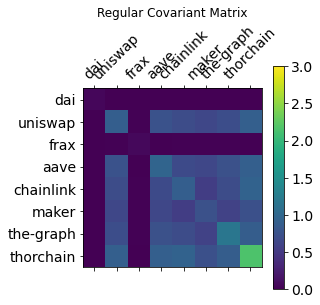

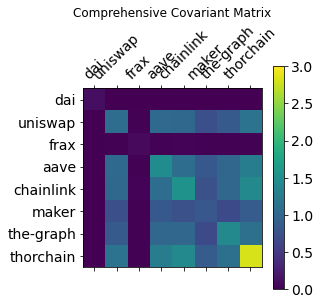

In [624]:
ca = CoinAnalyzer()

r = risk_models.risk_matrix(price_data, method='ledoit_wolf')
# print(r)

h = ca.cov_matrix(price_data, {}, False)
# print(h)


ca.plot_matrix(r, title="Regular Covariant Matrix")


ca.plot_matrix(h, title="Comprehensive Covariant Matrix")

In [625]:
# ## testing portfolios with different sentiments
# p = Portfolio('ABCD', 'one', ex_pref)
# print(p.assets)
# p.test_portfolio(5)

# p.update_prefs({'risk_appetite': 'mid'})
# print(p.assets)
# p.test_portfolio(5)

# p.update_prefs({'risk_appetite': 'high'})
# print(p.assets)
# p.test_portfolio(5)

## Testing Portfolio Rebalancing
How often is it necessary to rebalance a portfolio? Because crypto prices can change so quickly, it becomes imperative to routinely check the performance of the porfolio and balance accordingly. This following code models how rebalancing more often can provide better returns, not accounting for fees involved in trading. I will be using the 'mid' risk appetite in this example.

In [626]:
## making rebalance model

day_change = full_data.pct_change()
# print(day_change)


market_caps = [6.3, 2.7, 1.4, .94, 3.2, .95, .84, .66]

def rebal_model(folio, days, trigger):
    performance = []

    our_prices = copy.deepcopy(full_data)
    i = 1
    last_rebal = tr_days - 1
    performance.append(folio.cap)
    while i < days:
        perf = folio.test_portfolio(last_rebal, i)
        # folio.cap = perf
        performance.append(perf)
        if i > 1:
            change = np.average(np.abs(day_change.iloc[tr_days + i - 1]), weights=market_caps)
            # print(change) ## usually about .03-.04
            if change >= trigger:
                folio.cap = perf #- perf * .001
                our_prices_now = our_prices[10:tr_days + i - 1]

                folio.create_portfolio(our_prices_now)
                last_rebal = tr_days + i - 1
                
        i += 1

    # print(performance)
    return performance


def plot_rebal(datafrm, annotations):
    fig, ax = plt.subplots()
    datafrm.plot(ax=ax, legend=True,
        title='Value of the Portfolios with Different Rebalancing Strategies', ylabel='Value of Portfolio (USD)', cmap="viridis", ylim=(30, 140))
    
    if annotations:
        text = 'The following rebalancing triggers perform better than the index:\n'
        trigs = '\n'.join(annotations)
        text = text + trigs
        ax.text(.05, 1.05, text)

    plt.legend(loc=(1.04,0))
    # plt.tight_layout()
    plt.show()

In [627]:
model_days = 130

my_prefs = {
    'risk_appetite':'mid',
    'capital': 100,
    'sens': []
}

def model_compose(trigger_range, days, bl=False, benchmark=True):
    rebals = []

    for i, trigger in enumerate(trigger_range):
        if bl:
            p = BL_Portfolio('user_1', 'bl_portfolio', my_prefs)
        else:
            p = Portfolio('1', 'portfolio', my_prefs)
        this_t = rebal_model(p, days, trigger)
        rebals.append(this_t)

    names = [f'Rebalance trigger {np.round(i * 100)}%' for i in trigger_range]

    if benchmark:
        names.append('Defi Index')
        index_w = [ 1 / len(price_data.columns) for i in price_data.columns ]

        # print(index_w)
        index_port = Portfolio('1', 'index', my_prefs)
        index_port.set_weights(index_w)

        market_index = rebal_model(index_port, days, np.Infinity)
        rebals.append(market_index)

    rebals = list(map(list, zip(*rebals)))
    dfrebal = pd.DataFrame(rebals, columns=names)
    dfrebal.index.rename('Day', inplace=True)

    annotations = []
    if benchmark:
        for i, val in enumerate(dfrebal.iloc[-1]):
            if val > rebals[-1][-1]:
                annotations.append(trigger_range[i])

    annotations = [ f'{np.round(i * 100)}%' for i in annotations ]

    tfile = open('rebal.txt', 'w')
    tfile.write(dfrebal.to_string())
    tfile.close()

    return dfrebal, annotations


all_rebal = model_compose(np.asanyarray(range(0,11,2)) / 100, model_days)





/home/gloria/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


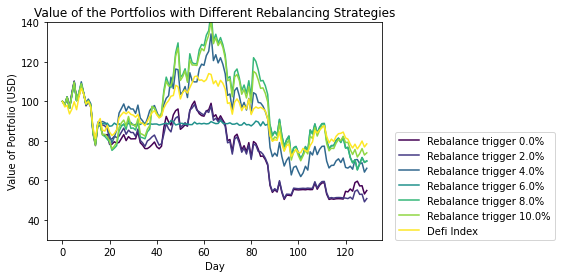

In [628]:
plot_rebal(all_rebal[0], all_rebal[1])

## Alternative Ways of Incorporating Risk into the Creation of a Portfolio
The Black-Litterman Model uses "a prior estimate of returns (for example, the market-implied returns) with views on certain assets, to produce a posterior estimate of expected returns" (Pyportfolio Opt. Documentation).

In [629]:
delta = black_litterman.market_implied_risk_aversion(pd.Series(np.average(price_data, weights=market_caps, axis=1)))
cov = risk_models.sample_cov(price_data)

# plt.matshow(market_caps)

mcaps = {
    'dai': market_caps[0],
    'uniswap': market_caps[1],
    'frax': market_caps[2],
    'aave': market_caps[3],
    'chainlink': market_caps[4],
    'maker': market_caps[5],
    'the-graph': market_caps[6],
    'thorchain': market_caps[7]
}

prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov)
qvector = np.array([.0005, .2, 0.0]).reshape(-1, 1)
picking = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, -.999, 0, .333, .333, .333, 0, 0],
        [1, 0, -1, 0, 0, 0, 0, 0]
    ]
)

my_bl = BlackLittermanModel(cov, pi=prior, Q=qvector, P=picking, weight_bounds=(0,1))


In [630]:
# my_bl.bl_weights()
# my_bl.portfolio_performance(verbose=True)

# my_bl.clean_weights()

# print(my_bl.weights)


## Making a Subclass for the Black-Litterman Portfolio models

In [631]:
class BL_Portfolio(Portfolio):
    def __init__(self, user_id: str, name: str, prefs: Preferences):
        Portfolio.__init__(self, user_id, name, prefs)


    def no_shorts(self):
        raw = list(self.assets.values())
        # print(raw)

        for i, w in enumerate(raw):
            if w < 0:
                raw[i] = 0

        no_short = np.asanyarray(raw) / np.sum(raw)
        # no_short = np.round(no_short,5)
        # print(np.sum(no_short))

        self.assets = dict(zip(self.assets.keys(), no_short))
        

    ## creating a portfolio
    def create_portfolio(self, prices=price_data, mark_caps=mcaps):
        delta = black_litterman.market_implied_risk_aversion(pd.Series(np.average(prices, weights=list(mcaps.values()), axis=1)))
        cov = risk_models.sample_cov(prices)

        prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov)
        qvector = np.array([.0002, .15, 0.0, .05]).reshape(-1, 1)
        picking = np.array(
            [
                [1, 0, 0, 0, 0, 0, 0, 0],
                [0, -.999, 0, .5, 0, .5, 0, 0],
                [1, 0, -1, 0, 0, 0, 0, 0],
                [0, 0, 0, -.5, 1, -.5, 0, 0]
            ]
        )

        bl = BlackLittermanModel(cov, pi=prior, Q=qvector, P=picking, weight_bounds=(0,1))

        bl.bl_weights()
        # my_bl.portfolio_performance(verbose=True)
        self.ef = bl
        self.assets = bl.clean_weights()
        self.no_shorts()

        self.last_rebal = datetime.date.today()

In [632]:
bl_test = model_compose(np.asanyarray(range(0,11,2)) / 100, model_days, True)

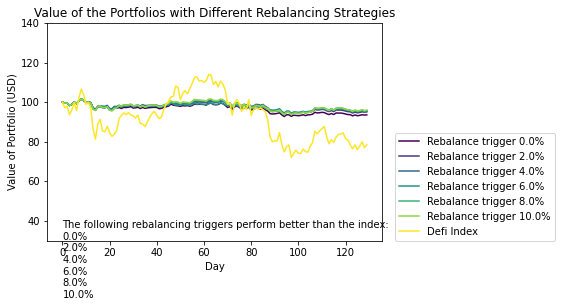

In [633]:
plot_rebal(bl_test[0], bl_test[1])